In [2]:
import numpy as np
import matplotlib.pyplot as plt
from search import *

In [3]:
border = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
wall_right = [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
wall_left = [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
two_walls = [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]

In [4]:
border = np.array(border)
wall_right = np.array(wall_right)
wall_left = np.array(wall_left)
two_walls = np.array(two_walls)


In [5]:
# Cria o board
board =[]

# Add parede de cima
board.append(border)

# Add 20 wall rights
board.extend([wall_right]*19)

# Add 20 wall duplas
board.extend([two_walls]*20)

# Add 20 wall lefts
board.extend([wall_left]*19)

# Add parede de baixo
board.append(border)

board = np.array(board)

print(board.shape)

(60, 60)


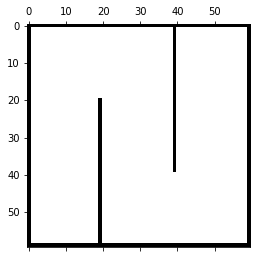

In [6]:
plt.matshow(board, cmap='gray')

In [7]:
state = {}
for i in range(60):
    for j in range(60):
        if board[i][j]:
            # Cria nós com as vizinhanças
            neighbors = {}
            if i-1 < 60 and board[i-1][j]:
                neighbors[60*(i-1)+j] = 1
            if i+1 < 60 and board[i+1][j]:
                neighbors[60*(i+1)+j] = 1
            if j-1 < 60 and board[i][j-1]:
                neighbors[60*i+j-1] = 1
            if j+1 < 60 and board[i][j+1]:
                neighbors[60*i+j+1] = 1

            state[60*i+j] = neighbors 

In [8]:
state = UndirectedGraph(state)

In [13]:
problem = GraphProblem(3010, 650, state)

In [23]:
len(breadth_first_graph_search(problem).solution())

122

In [24]:
len(depth_first_graph_search(problem).solution())

846

In [25]:
len(hill_climbing(problem).solution())

NotImplementedError: 